#DETR Finetune assignment
## By: Jeremy Rico
## Organization: TypeFace

Description:

This script finetunes the DETR object detection for two classes of the COCO
dataset.

It also creates a per class f1 score for inference images

Classes are:

1.   Cat
2.   Banana

Official DETR repository: https://github.com/facebookresearch/detr

DETR Finetune: https://github.com/woctezuma/finetune-detr


### Clone my repo for downloading coco annotations and images

In [1]:
!git clone https://github.com/jeremy-rico/DETR_finetune.git
%cd DETR_finetune

Cloning into 'DETR_finetune'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 97 (delta 47), reused 73 (delta 23), pack-reused 0
Receiving objects: 100% (97/97), 14.20 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/DETR_finetune


### Download necessary content

This script does a few things:

1. Downloads the COCO2017 train_val annotations
2. Creates a subset of the data which includes 100 samples of two classes and splits then using a 70, 15, 15 split ratio
3. Downloads pretrained DETR-50 weights and removes the classification head


In [2]:
!python3 download.py \
  --classes cat banana \
  --num_samples 100 \
  --split 0.7 0.15 0.15 \
  --coco_type trainval2017 \
  --out_dir data

Extracting annotations to data/annotations_trainval2017
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Preparing custom dataset...
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100% 159M/159M [00:01<00:00, 127MB/s]


## Data Exploration

Lets look over some of the data to make sure the download script worked properly

In [3]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from utils import run_infer, f_beta #personal library of helper functions
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
def show_img(img_id:int, dataDir:str, dataType:str)->None:
  """
  Shows the image of COCO img_id with annotations

  Arguments:
    img_id: coco image id number
    dataDir: directory where coco images are stored
    dataType: one of 'train' 'val' or 'test'

  Returns:
    None
  """
  plt.figure
  img = coco.loadImgs(img_id)[0]
  img_name = dataDir / f'{dataType}2017' / img['file_name']
  print(f"Image id: {img_id}")
  print(f"Image name: {img['file_name']}")

  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  I = io.imread(img_name)
  plt.imshow(I)
  coco.showAnns(anns, draw_bbox=True)

In [5]:
dataDir=Path('/content/DETR_finetune/data/custom/')
dataType='train'
annFile=dataDir / f'annotations/custom_{dataType}.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print(f'Categories: {nms}')

nms = set([cat['supercategory'] for cat in cats])
print(f'Super-categories: {nms}')

Categories: ['cat', 'banana']
Super-categories: {'food', 'animal'}


Lets take a look at some examples

### Cat Example

Image id: 157807
Image name: 000000157807.jpg


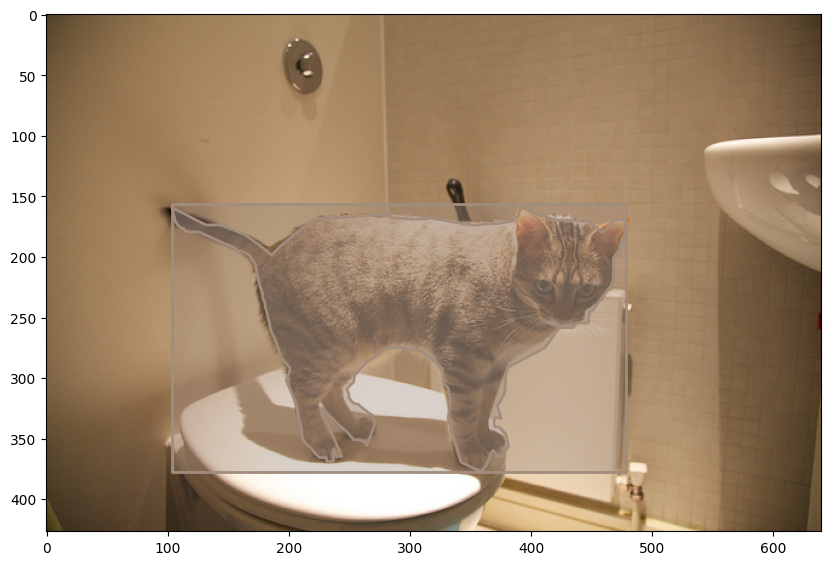

In [7]:
# load and display image
cat_catId = coco.getCatIds(catNms=['cat'])
imgIds = coco.getImgIds(catIds=cat_catId);
img_id = imgIds[np.random.randint(0,len(imgIds))]
show_img(img_id, dataDir, dataType)

### Banana Example

Image id: 59598
Image name: 000000059598.jpg


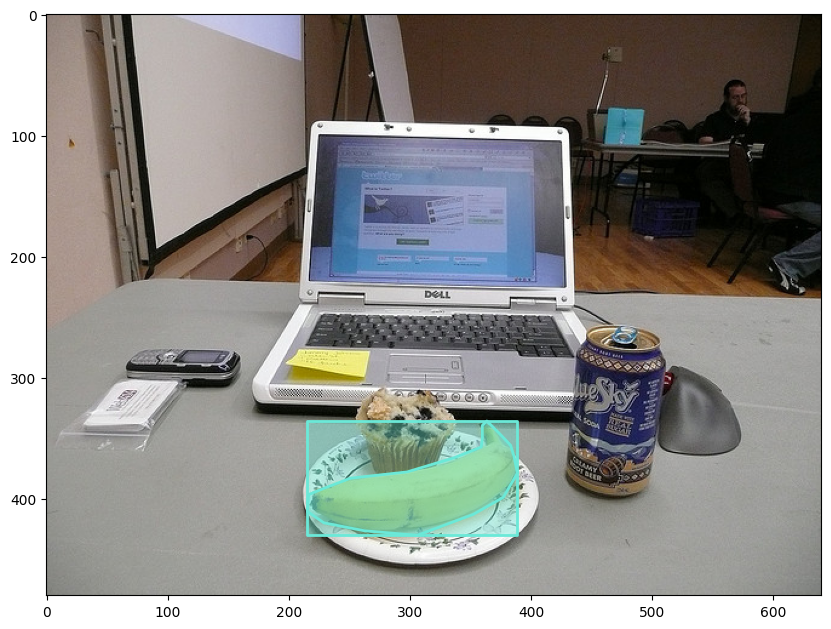

In [27]:
banana_catId = coco.getCatIds(catNms=['banana'])
imgIds = coco.getImgIds(catIds=banana_catId);
img_id = imgIds[np.random.randint(0,len(imgIds))]
show_img(img_id, dataDir, dataType)

## Difficulties of the banana class
Banana has proven to be a very difficult class. Mainly becuase of the amount of forms it can appear in and discrepencies in labeling. Banana appears in multiple forms:
* Bunch
* Single (peeled, unpeeled, partially peeled)
* Sliced (cooked, uncooked)

This variation makes it a difficult class to learn. Below are some examples.

For this reason I trained for 25 epochs instead of 10 which would have been fine for an easier class.

Bunched:
Image id: 161820
Image name: 000000161820.jpg


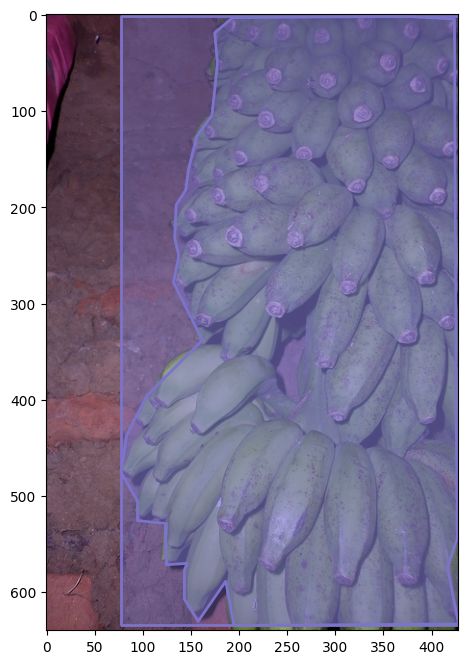

In [9]:
bunch_id = 161820
print("Bunched:")
show_img(bunch_id, dataDir, dataType)

Peeled:
Image id: 474854
Image name: 000000474854.jpg


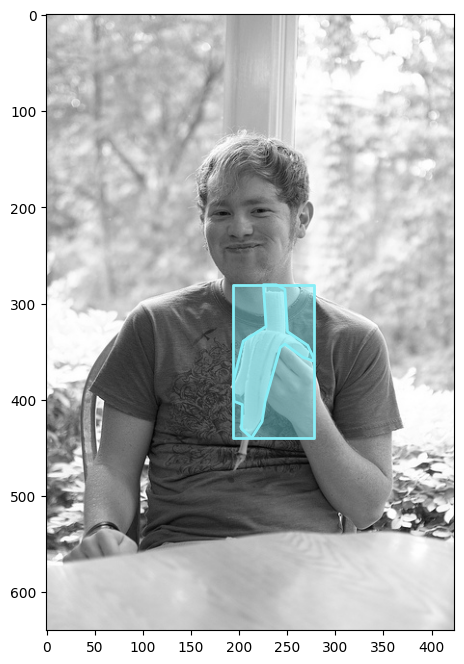

In [10]:
peeled_id = 474854
print("Peeled:")
show_img(peeled_id, dataDir, dataType)

Sliced:
Image id: 489305
Image name: 000000489305.jpg


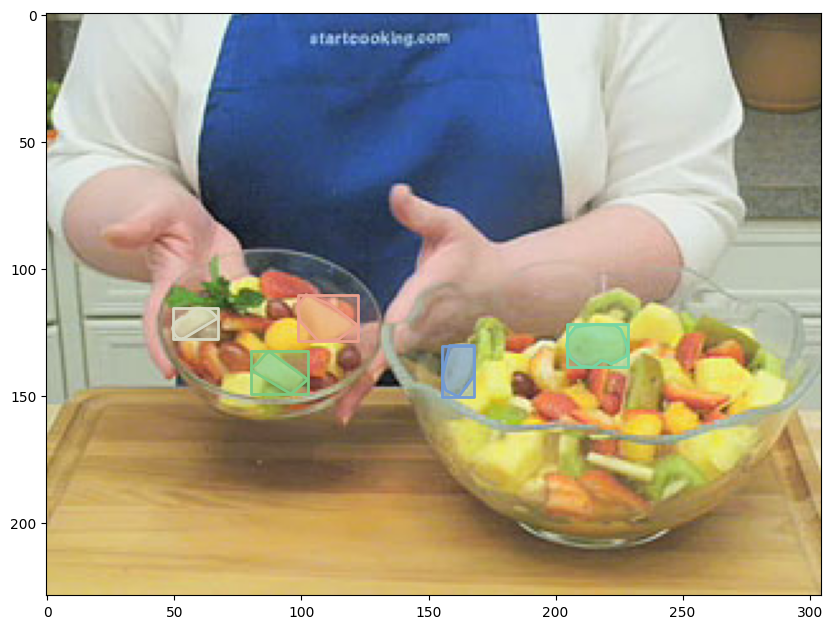

In [11]:
sliced_id = 489305
print("Sliced:")
show_img(sliced_id, dataDir, dataType)

wtf:
Image id: 90891
Image name: 000000090891.jpg


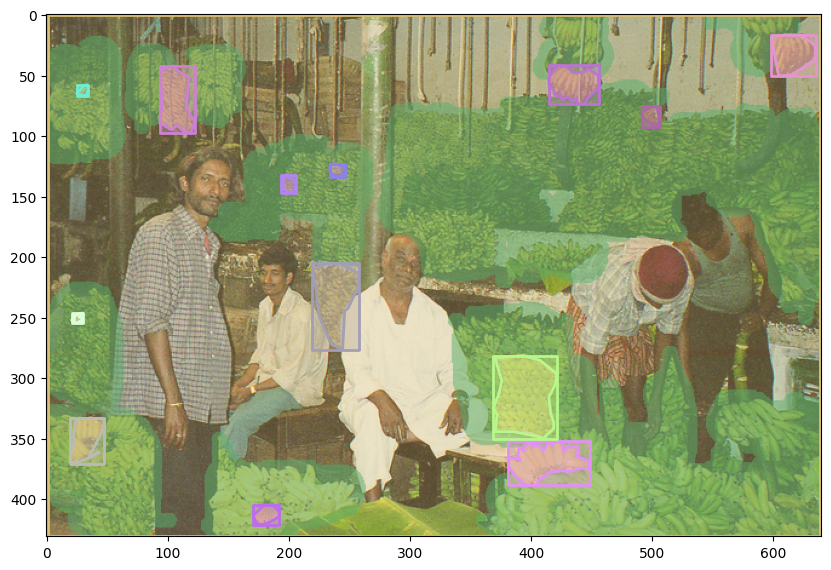

In [12]:
wtf_id = 90891
print("wtf:")
show_img(wtf_id, dataDir, dataType)

#Training

First we will clone the finetuning fork by woctezuma

Source: https://github.com/woctezuma/detr

In [13]:
!git clone https://github.com/woctezuma/detr.git
%cd detr
!git checkout finetune

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.68 KiB | 8.09 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/DETR_finetune/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


In [14]:
from util.plot_utils import plot_logs

Define our number of classes and names (num_classes can be 2 since we began our indexing at 0 in download.py)

In [15]:
num_classes = 2
dataDir_str = str(dataDir)
out_dir = "/content/DETR_finetune/outputs"
model_path = "/content/DETR_finetune/model/detr-r50_no-class-head.pth"

Train!
(I cleared the output of this cell since it was way too long)

In [ ]:
!python3 main.py \
  --dataset_file "custom" \
  --coco_path $dataDir_str \
  --output_dir $out_dir \
  --resume $model_path \
  --num_classes $num_classes \
  --epochs 50 #25

/content/DETR_finetune/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


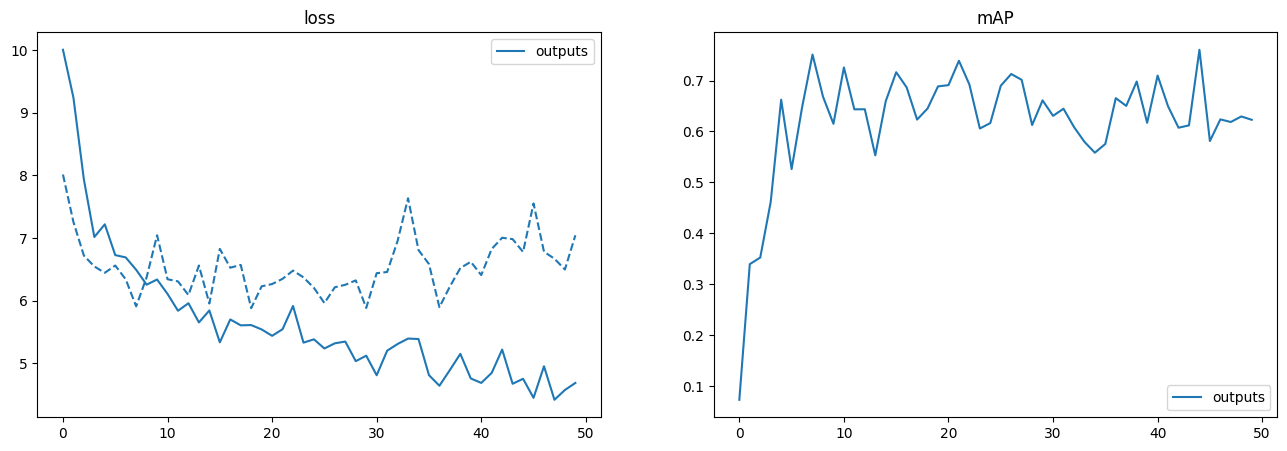

In [17]:
log_directory = [Path(out_dir)]
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/DETR_finetune/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/DETR_finetune/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/DETR_finetune/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='ob

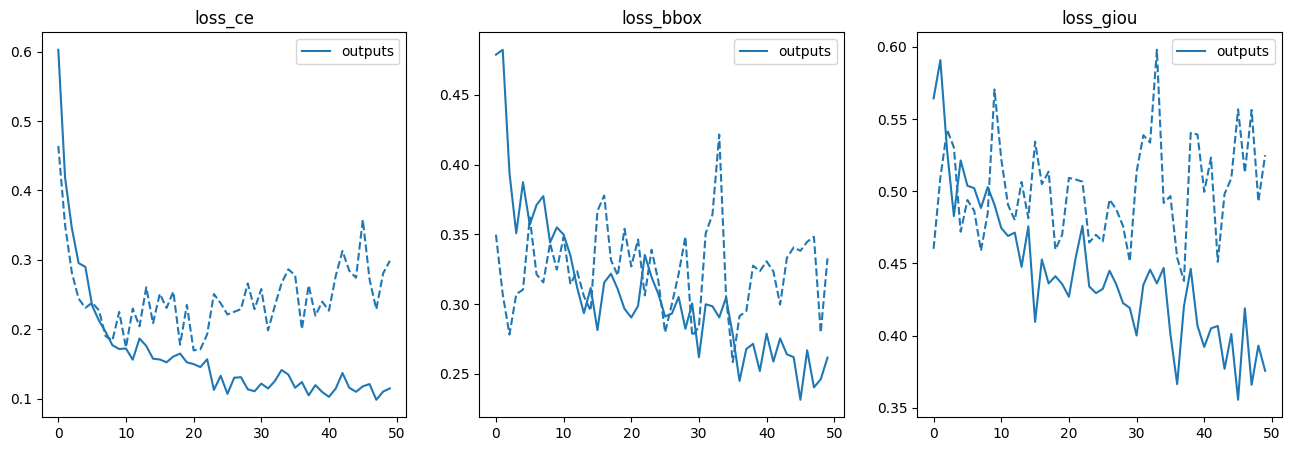

In [18]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

#Inference

First lets load the trained model into memory

In [19]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load(Path(out_dir) / 'checkpoint.pth',
                        map_location='cuda')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we will run inference on all the images in our coco test file. Model outputs will be saved in outputs. Converted COCO labels will be stored in targets (see utils.py for more info)

In [24]:
test_annFile = dataDir / f'annotations/custom_test.json'
test_coco = COCO(test_annFile)

outputs, targets = run_infer(test_coco, model, dataDir)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Running inference...: 100%|██████████| 30/30 [01:54<00:00,  3.80s/it]


#F1-score for inference images
The f_beta function does three things (see utils.py for full description)

1. performs bipartite matching on model outputs to match each annotation with a predicted box in way that minimizes overall cost
2. calculates the confusion matrix of each class
3. calculates the f_beta score for each class (we will use beta = 1)

This will then output a dictinary where each class name is mapped to its f1 score. It also uses a confidence and giou threshold to determine the confusion matrix.

In [23]:
giou = [0.5, 0.7, 0.9]
conf = [0.6, 0.7, 0.8]

for giou_thresh, conf_thresh in zip(giou, conf):
  print(f"\ngiou threshold: {giou_thresh}, confidence_threshold: {conf_thresh}")
  per_cls_f1 = f_beta(test_coco, outputs, targets,
                      giou_thresh, conf_thresh, beta=1)

  for cls, f1 in per_cls_f1.items():
    print(f"Class name: {cls:>6}, f1-score: {f1:.3}")


giou threshold: 0.5, confidence_threshold: 0.6
Class name:    cat, f1-score: 0.579
Class name: banana, f1-score: 0.257

giou threshold: 0.7, confidence_threshold: 0.7
Class name:    cat, f1-score: 0.5
Class name: banana, f1-score: 0.18

giou threshold: 0.9, confidence_threshold: 0.8
Class name:    cat, f1-score: 0.258
Class name: banana, f1-score: 0.107


As you can see, we performed significantly worse on the banana class which is to be suspected because of what we discussed before. Also note how increasing the giou threshold increases false negatives whereas increasng the confidence threshold decreases false positives.